In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding,LSTM,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras import regularizers
import pickle
import numpy as np
import os
import pandas as pd
import re

# from google.colab import drive
# drive.mount('/content/drive')
# %cp -av "/content/drive/MyDrive/fknews.txt" "/content"

In [2]:
# Load the JSON file into a dictionary
import json
with open('syntheticPC.json', 'r') as f:
    data = json.load(f)

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(data)

# Print the unique values in the 'tag' column
print(df['tag'].unique())
df.head()

['phone call' 'meeting' 'face-to-face conversation' 'general chatting'
 'presentation' 'training']


,id,tag,title,original_language,conversation
0,190329_J07_03,phone call,伝言への折り返し電話打ち合わせ日程調整,ja,"[{'no': 1, 'ja_speaker': '土井さん', 'en_speaker':..."
1,190329_J06_11,meeting,株主総会に関する役員向け説明（２）,ja,"[{'no': 1, 'ja_speaker': '高田さん', 'en_speaker':..."
2,190329_J06_10,meeting,株主総会に関する役員向け説明（１）,ja,"[{'no': 1, 'ja_speaker': '友井さん', 'en_speaker':..."
3,190329_J06_09,face-to-face conversation,信託銀行から株主名簿を受領,ja,"[{'no': 1, 'ja_speaker': '高田さん', 'en_speaker':..."
4,190329_J06_08,face-to-face conversation,株主総会への臨場要請,ja,"[{'no': 1, 'ja_speaker': '高田さん', 'en_speaker':..."


In [3]:
df_convs = pd.concat([pd.json_normalize(df['conversation'][i]) for i in range(len(df))],ignore_index=True)
train_en = df_convs["en_sentence"].values.tolist()

In [4]:
train_en[:10]

['Hi this is the systems development department of Company K.',
 'My name is Takaichi from Company H.',
 'Thank you as always.',
 'Thank you as always as well.',
 'Is Inada-san there?',
 'It seems I got a call from him around 1 hour ago.',
 'Yes, let me switch you over.',
 'Please wait a moment.',
 'Inada-san, you have a call from Mr. Takaichi of Company H.',
 'Hello, this is Inada.']

In [5]:
text = ' '.join(train_en[:10000])
print('length of the corpus is: :', len(text))
del data

length of the corpus is: : 532978


In [6]:
tokens = text.split(" ")
tokens = list(filter(lambda t: t != "", tokens))
tokens

['Hi',
 'this',
 'is',
 'the',
 'systems',
 'development',
 'department',
 'of',
 'Company',
 'K.',
 'My',
 'name',
 'is',
 'Takaichi',
 'from',
 'Company',
 'H.',
 'Thank',
 'you',
 'as',
 'always.',
 'Thank',
 'you',
 'as',
 'always',
 'as',
 'well.',
 'Is',
 'Inada-san',
 'there?',
 'It',
 'seems',
 'I',
 'got',
 'a',
 'call',
 'from',
 'him',
 'around',
 '1',
 'hour',
 'ago.',
 'Yes,',
 'let',
 'me',
 'switch',
 'you',
 'over.',
 'Please',
 'wait',
 'a',
 'moment.',
 'Inada-san,',
 'you',
 'have',
 'a',
 'call',
 'from',
 'Mr.',
 'Takaichi',
 'of',
 'Company',
 'H.',
 'Hello,',
 'this',
 'is',
 'Inada.',
 'This',
 'is',
 'Takaichi',
 'from',
 'Company',
 'H.',
 'Thank',
 'you.',
 'Thank',
 'you',
 'as',
 'always.',
 'Thank',
 'you',
 'for',
 'the',
 'call',
 'earlier.',
 'Sorry',
 'I',
 'was',
 'out.',
 'Not',
 'at',
 'all,',
 "I'm",
 'also',
 'sorry',
 'for',
 'calling',
 'when',
 'you',
 'were',
 'busy.',
 'We',
 'are',
 'going',
 'to',
 'Company',
 'A',
 'next',
 'Monday,',
 'ri

In [7]:
train_len = 5+1

text_sequences = []

for i in range(train_len, len(tokens)):

    seq = tokens[i-train_len:i]

    text_sequences.append(seq)

In [8]:
' '.join(text_sequences[0])

'Hi this is the systems development'

In [9]:
len(text_sequences) #Every sentence is containing 26 words

99691

In [10]:
len(tokens) # These are total number of words in the whole novel

99697

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences)

In [12]:
del text
print(len(sequences[0]))
print(sequences[0])

6
[645, 19, 7, 1, 1055, 436]


In [13]:
del text_sequences
tokenizer.index_word

{1: 'the',
 2: 'i',
 3: 'to',
 4: 'you',
 5: 'a',
 6: 'it',
 7: 'is',
 8: 'and',
 9: 'of',
 10: 'for',
 11: 'we',
 12: 'in',
 13: 'that',
 14: 'be',
 15: 'will',
 16: 'have',
 17: 'so',
 18: 'can',
 19: 'this',
 20: 'on',
 21: 'if',
 22: 'are',
 23: 'but',
 24: 'with',
 25: 'from',
 26: 'as',
 27: 'about',
 28: 'your',
 29: 'at',
 30: 'do',
 31: 'like',
 32: 'yes,',
 33: 'thank',
 34: 'was',
 35: "it's",
 36: 'there',
 37: 'my',
 38: 'our',
 39: 'not',
 40: 'would',
 41: 'what',
 42: 'they',
 43: 'think',
 44: 'how',
 45: 'company',
 46: "i'm",
 47: 'oh,',
 48: 'please',
 49: "that's",
 50: 'me',
 51: 'when',
 52: 'an',
 53: 'by',
 54: 'get',
 55: 'you.',
 56: 'just',
 57: 'all',
 58: 'good',
 59: 'should',
 60: 'it.',
 61: 'time',
 62: 'go',
 63: "don't",
 64: 'up',
 65: 'he',
 66: 'know',
 67: 'then',
 68: 'next',
 69: 'okay,',
 70: 'need',
 71: 'one',
 72: 'very',
 73: "i'll",
 74: 'them',
 75: 'people',
 76: 'take',
 77: 'make',
 78: 'going',
 79: 'well,',
 80: 'any',
 81: 'more',


In [14]:
vocabulary_size = len(tokenizer.word_counts)+1
vocabulary_size

9774

In [15]:
sequences = np.array(sequences)
sequences.shape

(99691, 6)

In [16]:
model = Sequential()
model.add(Embedding(vocabulary_size, 50, input_length=5))
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(150))
model.add(Dense(150, activation='relu'))

model.add(Dense(vocabulary_size, activation='softmax', activity_regularizer=regularizers.L2(0.001)))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 50)             488700    
                                                                 
 lstm (LSTM)                 (None, 5, 150)            120600    
                                                                 
 lstm_1 (LSTM)               (None, 150)               180600    
                                                                 
 dense (Dense)               (None, 150)               22650     
                                                                 
 dense_1 (Dense)             (None, 9774)              1475874   
                                                                 
Total params: 2288424 (8.73 MB)
Trainable params: 2288424 (8.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
X = sequences[:,:-1]
X.shape

(99691, 5)

In [18]:
Y = sequences[:,-1]
del sequences
Y.shape

(99691,)

In [19]:
Y = to_categorical(Y, num_classes=vocabulary_size)
Y.shape

(99691, 9774)

In [20]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y)

In [21]:
his = model.fit(X, Y, batch_size=256, epochs=50,verbose=1,validation_split=0.1)

Epoch 1/50
351/351 [==============================] - 26s 57ms/step - loss: 7.0273 - accuracy: 0.0426 - val_loss: 6.7921 - val_accuracy: 0.0442
Epoch 2/50
351/351 [==============================] - 9s 27ms/step - loss: 6.6742 - accuracy: 0.0444 - val_loss: 6.7026 - val_accuracy: 0.0442
Epoch 3/50
351/351 [==============================] - 8s 23ms/step - loss: 6.4906 - accuracy: 0.0524 - val_loss: 6.5027 - val_accuracy: 0.0677
Epoch 4/50
351/351 [==============================] - 8s 22ms/step - loss: 6.1668 - accuracy: 0.0721 - val_loss: 6.3431 - val_accuracy: 0.0863
Epoch 5/50
351/351 [==============================] - 8s 22ms/step - loss: 5.8528 - accuracy: 0.0965 - val_loss: 6.1784 - val_accuracy: 0.1084
Epoch 6/50
351/351 [==============================] - 8s 22ms/step - loss: 5.5501 - accuracy: 0.1184 - val_loss: 6.0874 - val_accuracy: 0.1199
Epoch 7/50
351/351 [==============================] - 7s 21ms/step - loss: 5.2981 - accuracy: 0.1319 - val_loss: 6.0841 - val_accuracy: 0.128

In [22]:
# Sleep for a few seconds.
import time
time.sleep(2)

# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [23]:
# save the model to file
model.save('lstmn5epoch100.h5')
# save the tokenizer
pickle.dump(tokenizer, open('lstmn5tok.sav', 'wb'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


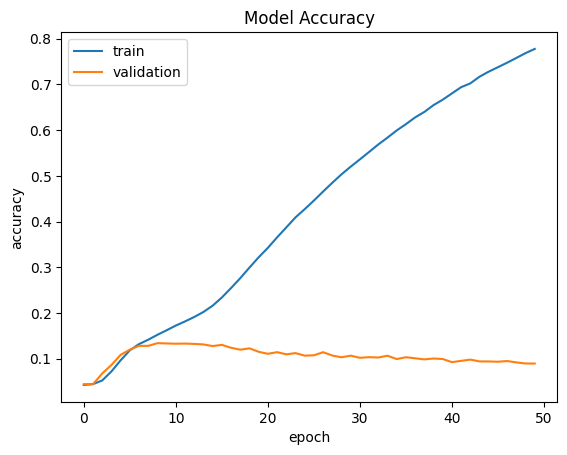

In [24]:
import matplotlib.pyplot as plt

plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

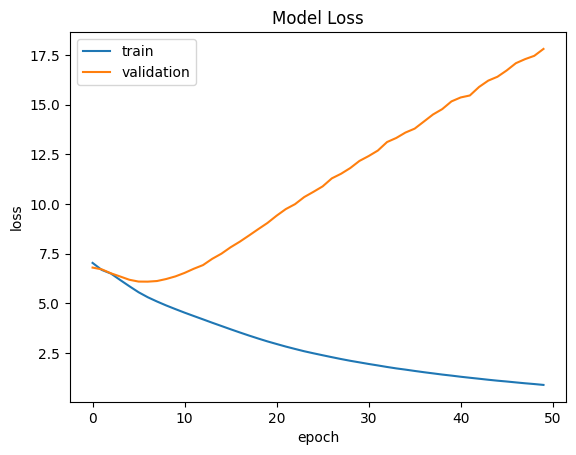

In [25]:
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
from keras.preprocessing.sequence import pad_sequences

def generate_text(model, tokenizer, seq_len, seed_text, num_gen_words):
    '''
    INPUTS:
    model : model that was trained on text data
    tokenizer : tokenizer that was fit on text data
    seq_len : length of training sequence
    seed_text : raw string text to serve as the seed
    num_gen_words : number of words to be generated by model
    '''

    # Final Output
    output_text = []

    # Intial Seed Sequence
    input_text = seed_text

    # Create num_gen_words
    for i in range(num_gen_words):

        # Take the input text string and encode it to a sequence
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]

        # Pad sequences to our trained rate (25 words in the video)
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')

        # Predict Class Probabilities for each word
        #pred_word_ind = model.predict_classes(pad_encoded, verbose=0)[0]
        predict_x=model.predict(pad_encoded)
        pred_word_ind=np.argmax(predict_x,axis=1)[0]
        #print(pred_word_ind)
        # Grab word
        pred_word = tokenizer.index_word[pred_word_ind]

        # Update the sequence of input text (shifting one over with the new word)
        input_text += ' ' + pred_word

        output_text.append(pred_word)

    # Make it look like a sentence.
    return ' '.join(output_text)


In [27]:
generate_text(model,tokenizer,5,seed_text="The quick brown fox jumps",num_gen_words=3)

1/1 [==============================] - 0s 17ms/step


'explain me how'